In [1]:
import numpy as np
import torch

from dispNN import dispNN
from densNN import densNN, fourier_map
from loss import energy_vol
from mesh import generate_points
from utils import plotTO

def set_seed(seed=1234):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed()

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# -------------------- Geometry & loading --------------------
geom = {"xmin": 0.0, "ymin": 0.0, "xmax": 1.0, "ymax": 1.0}
force = -1.0
load_frac = 0.02 * (geom["xmax"] - geom["xmin"])
domain_area = (geom["xmax"] - geom["xmin"]) * (geom["ymax"] - geom["ymin"])
#  Material (SIMP)
mat = {"nu": 0.3, "E0": 1.0, "Emin": 1e-9, "penal": 3, "vol_frac": 0.5}
grid = {"nx": 100, "ny": 100}
ff_cfg = {"n_feat": 150, "std": 2.0}
B = torch.as_tensor(np.random.normal(0, ff_cfg["std"], (2,ff_cfg["n_feat"])),
    device=DEVICE, dtype=torch.float32)
# -------------------- Network architecture --------------------
net_cfg = {"disp": {"layers": 4, "width": 25, "in_dim": 2},
        "dens": {"layers": 2, "width": 25, "in_dim": 2 * ff_cfg["n_feat"]},}

# -------------------- Training setup --------------------
train_cfg = {
    "lr_u": 1e-4,
    "lr_rho": 1e-2,
    "epochs": 100,
    "pre_disp": 500,
    "disp_steps": 60,
    "lam": 50,
    "tol": 0.05,
}

In [3]:
# -------------------- Networks --------------------
u_model = dispNN(net_cfg["disp"]["in_dim"],
               net_cfg["disp"]["layers"],
               net_cfg["disp"]["width"]).to(DEVICE)

v_model = dispNN(net_cfg["disp"]["in_dim"],
               net_cfg["disp"]["layers"],
               net_cfg["disp"]["width"]).to(DEVICE)

rho_model = densNN(net_cfg["dens"]["in_dim"],
                 net_cfg["dens"]["layers"],
                 net_cfg["dens"]["width"]).to(DEVICE)

# -------------------- Optimizers --------------------
opt_disp = torch.optim.Adam(
    list(u_model.parameters()) + list(v_model.parameters()),
    lr=train_cfg["lr_u"],
    amsgrad=True)
opt_dens = torch.optim.Adam(
    rho_model.parameters(),
    lr=train_cfg["lr_rho"],
    amsgrad=True)
loss_mse = torch.nn.MSELoss()

In [4]:
# -------------------- Collocation & boundary points --------------------
x_all, y_all, Xg, Yg, fixed_mask, load_pt_mask_b, load_pt_mask_t = generate_points(geom["xmin"], 
            geom["ymin"], geom["xmax"], geom["ymax"], grid["nx"], grid["ny"], device=DEVICE)
load_pt_mask = load_pt_mask_t | load_pt_mask_b
# Exclude load point from collocation
free_mask = ~load_pt_mask

Xc = x_all[free_mask].view(-1, 1)
Yc = y_all[free_mask].view(-1, 1)

X_fix = x_all[fixed_mask].view(-1, 1)
Y_fix = y_all[fixed_mask].view(-1, 1)

X_load_b = x_all[load_pt_mask_b].view(-1, 1)
Y_load_b = y_all[load_pt_mask_b].view(-1, 1)

X_load_t = x_all[load_pt_mask_t].view(-1, 1)
Y_load_t = y_all[load_pt_mask_t].view(-1, 1)
# -------------------- Boundary ansatz --------------------
u_bc = 0.0                     # prescribed displacement
# bc_shape = X                   # vanishing function at fixed boundary

def eval_density(xc, yc, rho_model, proj_mat):
    features = fourier_map(xc, yc, proj_mat)
    return rho_model(features)

In [5]:
# -------------------- Displacement pretraining --------------------
print("Pretraining displacement network...")
rho_field = eval_density(Xc, Yc, rho_model, B)

for ep in range(train_cfg["pre_disp"]):
    opt_disp.zero_grad()
    # External work
    nb, nt = X_load_b.numel(), X_load_t.numel()
    v_b = v_model(X_load_b, Y_load_b)
    v_t = v_model(X_load_t, Y_load_t)
    u_b = u_model(X_load_b, Y_load_b)
    u_t = u_model(X_load_t, Y_load_t)
    ext_energy = load_frac * (
        force   * torch.sum(X_load_b * v_b) / nb
    - force   * torch.sum(X_load_t * v_t) / nt
    - force * torch.sum(X_load_b * u_b) / nb
    - force * torch.sum(X_load_t * u_t) / nt
    )

    # Internal energy
    int_energy, vol_frac = energy_vol(u_bc, Xc, Yc, u_model, v_model, rho_field,
        mat["Emin"], mat["E0"], mat["penal"], mat["nu"], domain_area)
    total_energy = -(ext_energy - int_energy)
    total_energy.backward(retain_graph=True)
    opt_disp.step()
J0 = abs(total_energy.item())
print(f"Initial energy reference J0 = {J0:.4e}")


Pretraining displacement network...
Initial energy reference J0 = 3.8832e-02


In [6]:
# ---- Displacement equilibration step ----
def train_disp(density_field):
    for _ in range(train_cfg["disp_steps"]):
        opt_disp.zero_grad()
        # Internal energy
        int_energy, vol_frac = energy_vol(u_bc, Xc, Yc, u_model, v_model, density_field,
            mat["Emin"], mat["E0"], mat["penal"], mat["nu"], domain_area)
        # External work
        nb, nt = X_load_b.numel(), X_load_t.numel()
        v_b = v_model(X_load_b, Y_load_b)
        v_t = v_model(X_load_t, Y_load_t)
        u_b = u_model(X_load_b, Y_load_b)
        u_t = u_model(X_load_t, Y_load_t)
        ext_energy = load_frac * (
            force   * torch.sum(X_load_b * v_b) / nb
        - force   * torch.sum(X_load_t * v_t) / nt
        - force * torch.sum(X_load_b * u_b) / nb
        - force * torch.sum(X_load_t * u_t) / nt
        )
        # disp_load = u_bc + X_load * v_model(X_load, Y_load)
        # ext_energy = torch.sum(force * disp_load) * (load_frac / X_load.shape[0])
        # Objective
        total_energy = -(ext_energy - int_energy)
        vol_penalty = (1.0 - vol_frac / mat["vol_frac"]) ** 2
        obj = total_energy / J0 + train_cfg["lam"] * vol_penalty
        obj.backward(retain_graph=True)
        opt_disp.step()

In [7]:
print("Starting coupled DPNN-TO optimization...")
for itr in range(2, train_cfg["epochs"] + 1):
    # ---- Displacement equilibration (ρ fixed) ----
    train_disp(rho_field)
    # ---- Density update ----
    opt_dens.zero_grad()
    rho_field = eval_density(Xc, Yc, rho_model, B)
    int_energy, vol_frac = energy_vol(u_bc, Xc, Yc, u_model, v_model, rho_field,
        mat["Emin"], mat["E0"], mat["penal"], mat["nu"], domain_area)
    
    nb, nt = X_load_b.numel(), X_load_t.numel()
    v_b = v_model(X_load_b, Y_load_b)
    v_t = v_model(X_load_t, Y_load_t)
    u_b = u_model(X_load_b, Y_load_b)
    u_t = u_model(X_load_t, Y_load_t)
    ext_energy = load_frac * (
        force   * torch.sum(X_load_b * v_b) / nb
    - force   * torch.sum(X_load_t * v_t) / nt
    - force * torch.sum(X_load_b * u_b) / nb
    - force * torch.sum(X_load_t * u_t) / nt
    )
    # disp_load = u_bc + X_load * v_model(X_load, Y_load)
    # ext_energy = torch.sum(force * disp_load) * (load_frac / X_load.shape[0])
    total_energy = ext_energy - int_energy
    vol_penalty = (1.0 - vol_frac / mat["vol_frac"]) ** 2
    dens_loss = total_energy / J0 + train_cfg["lam"] * vol_penalty
    dens_loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_(rho_model.parameters(), 0.1)
    opt_dens.step()
    # ---- Convergence monitoring (no gradients) ----
    with torch.no_grad():
        rho_field = eval_density(Xc, Yc, rho_model, B)
        gray_ratio = torch.sum((rho_field > 0.1) & (rho_field < 0.9)).item() / rho_field.numel()
    if gray_ratio < train_cfg["tol"]:
        print(f"Converged at {itr} iteration.")
        break
    print(f"Iter {itr} | " f"E={total_energy:.4e} | " f"Vf={vol_frac:.4e} | " f"gray={gray_ratio:.4f}")

Starting coupled DPNN-TO optimization...
Iter 2 | E=4.0442e-02 | Vf=4.8461e-01 | gray=0.9806
Iter 3 | E=8.2293e-03 | Vf=5.1939e-01 | gray=0.9565
Iter 4 | E=9.9424e-03 | Vf=4.8543e-01 | gray=0.9568
Iter 5 | E=9.3720e-03 | Vf=4.9756e-01 | gray=0.9604
Iter 6 | E=8.1197e-03 | Vf=5.2549e-01 | gray=0.9582
Iter 7 | E=8.1750e-03 | Vf=5.2659e-01 | gray=0.9553
Iter 8 | E=8.7979e-03 | Vf=5.1303e-01 | gray=0.9523
Iter 9 | E=9.6992e-03 | Vf=4.9233e-01 | gray=0.9506
Iter 10 | E=9.4500e-03 | Vf=4.8855e-01 | gray=0.9501
Iter 11 | E=8.5380e-03 | Vf=4.9582e-01 | gray=0.9512
Iter 12 | E=7.5367e-03 | Vf=5.0994e-01 | gray=0.9497
Iter 13 | E=7.1822e-03 | Vf=5.1284e-01 | gray=0.9468
Iter 14 | E=7.1368e-03 | Vf=5.0741e-01 | gray=0.9417
Iter 15 | E=7.2239e-03 | Vf=4.9596e-01 | gray=0.9288
Iter 16 | E=7.0517e-03 | Vf=4.9340e-01 | gray=0.9070
Iter 17 | E=6.7361e-03 | Vf=4.9808e-01 | gray=0.8862
Iter 18 | E=6.3357e-03 | Vf=5.0811e-01 | gray=0.8630
Iter 19 | E=6.1477e-03 | Vf=5.1019e-01 | gray=0.8232
Iter 20 | E=6

Iter 84, E=1.3506e-02, Vf=5.0106e-01, gray=0.0484


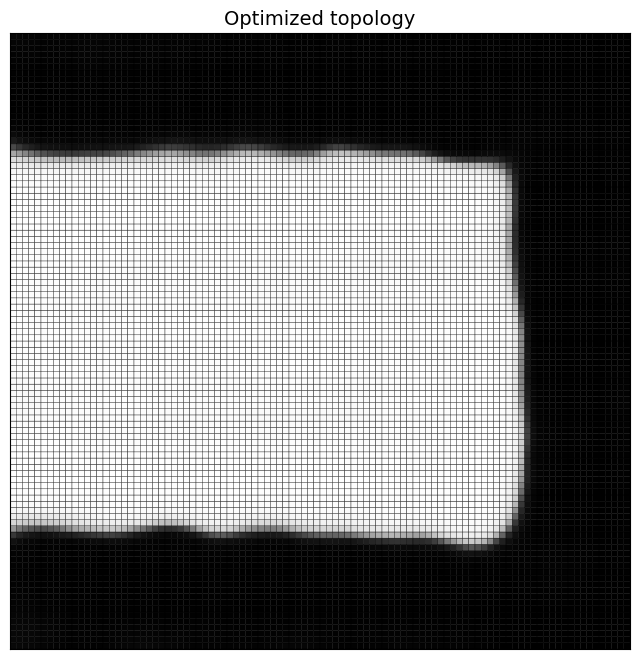

In [8]:
print(f"Iter {itr}, E={total_energy:.4e}, Vf={vol_frac:.4e}, gray={gray_ratio:.4f}")
# ---- Density for visualization ----
with torch.no_grad():
    rho_vis = rho_model(fourier_map(x_all, y_all, B)).detach().cpu().numpy().reshape(Xg.shape)

plotTO(Xg, Yg, rho_vis)

# ---- Save density field ----
import h5py
rho_save = rho_vis.astype(np.float64)
with h5py.File("ms_rho.h5", "w") as f:
    f.create_dataset("ms_rho", data=rho_save)
